# Fraud Detection in Electricity and Gas Consumption

The Tunisian Company of Electricity and Gas (STEG) is a public and a non-administrative company, it is responsible for delivering electricity and gas across Tunisia. The company suffered tremendous losses in the order of 200 million Tunisian Dinars due to fraudulent manipulations of meters by consumers.

Using the client’s billing history, the aim of the challenge is to detect and recognize clients involved in fraudulent activities.

The solution will enhance the company’s revenues and reduce the losses caused by such fraudulent activities.

# Team 5

## Data analysis and inspection

First thing we need to do is import the neccessary packages that we are going to be using.

In [173]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import Counter

sns.set()

%matplotlib inline

Loading the datasets into our file as a pandas dataframe

In [174]:
client_data = pd.read_csv('Data/client_train.csv',low_memory = False)
invoice_data = pd.read_csv('Data/invoice_train.csv',low_memory = False)

# Client training data

Taking a peek at the client dataset to see what kind of monster we are dealing with.

In [175]:
client_data.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [176]:
client_data.shape

(135493, 6)

# Invoice training data

We also look at the invoice dataset

In [177]:
invoice_data.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [178]:
invoice_data.shape

(4476749, 16)

We see that we can immediatly calculate how many invoices there are per client and add that to our dataframe

In [179]:
client_data['invoice_amount'] = invoice_data.groupby('client_id').size().values
client_data.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_amount
0,60,train_Client_0,11,101,31/12/1994,0.0,35
1,69,train_Client_1,11,107,29/05/2002,0.0,37
2,62,train_Client_10,11,301,13/03/1986,0.0,18
3,69,train_Client_100,11,105,11/07/1996,0.0,20
4,62,train_Client_1000,11,303,14/10/2014,0.0,14


# Date formating and examination

We also see that we can change the dates to datetime format incase we will be needing that information later

In [180]:
# Changing the client_data's column date to datetime
client_data['creation_date']= pd.to_datetime(client_data['creation_date'])
# Changing the invoice_data's column date to datetime
invoice_data['invoice_date']= pd.to_datetime(invoice_data['invoice_date'])

The date can be used to calculate how long a customer has had a contract with the company because it might be usefull in our model

In [181]:
today = pd.to_datetime("today")
# Add the contract length in years 
client_data['contract_time_length'] = today.year - client_data['creation_date'].dt.year
client_data.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_amount,contract_time_length
0,60,train_Client_0,11,101,1994-12-31,0.0,35,27
1,69,train_Client_1,11,107,2002-05-29,0.0,37,19
2,62,train_Client_10,11,301,1986-03-13,0.0,18,35
3,69,train_Client_100,11,105,1996-11-07,0.0,20,25
4,62,train_Client_1000,11,303,2014-10-14,0.0,14,7


The date of the last invoice can differ a lot from the current date and so the number of years since the start of a clients contract with the company and the date of their last invoice will be used as well.

In [182]:
client_data['contract_time_to_latest'] = invoice_data.groupby('client_id')['invoice_date'].max().dt.year.values- client_data['creation_date'].dt.year.values
    
client_data.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_amount,contract_time_length,contract_time_to_latest
0,60,train_Client_0,11,101,1994-12-31,0.0,35,27,25
1,69,train_Client_1,11,107,2002-05-29,0.0,37,19,17
2,62,train_Client_10,11,301,1986-03-13,0.0,18,35,33
3,69,train_Client_100,11,105,1996-11-07,0.0,20,25,16
4,62,train_Client_1000,11,303,2014-10-14,0.0,14,7,5


Detailed decriptions of the old and new index columns was not given for the dataset however is thought that the change in this index might be of value.

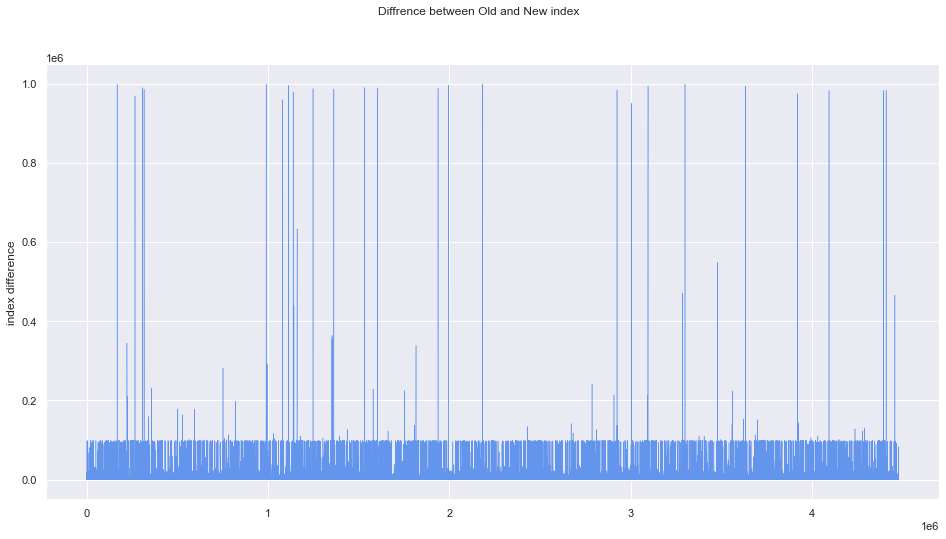

In [183]:
sns.set_style("darkgrid")
fig,ax = plt.subplots(figsize=(16,8))
invoice_data['index_dif'] = np.abs(invoice_data['new_index']-invoice_data['old_index'])
invoice_data.loc[:,'index_dif'].plot(c = "cornflowerblue", lw = 0.5)
plt.ylabel('index difference');
fig.suptitle("Diffrence between Old and New index");

There are large fluctuations in the difference of this value. Seeing how large difference values correspond to fraudulent clients is shown below:

In [184]:
print('0.75 quantile: ',invoice_data['index_dif'].quantile(0.75))
invoice_data.merge(client_data,on='client_id')[invoice_data['index_dif'] > invoice_data['index_dif'].quantile(0.75)]['target'].mean()*100

0.75 quantile:  657.0


8.796826157554776

8.8% of the values greater than the 0.75 quantile corresponds to fraudulent clients

# Looking at months

The months number column was also not well defined. It is seen that this number is how many months have passed since the last invoice/inspection. However there are large outiers for this feature corresponding to 200+ years since the last invoice.

In [185]:
invoice_data['months_number'].describe()

count    4.476749e+06
mean     4.483095e+01
std      3.128335e+03
min      0.000000e+00
25%      4.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      6.366240e+05
Name: months_number, dtype: float64

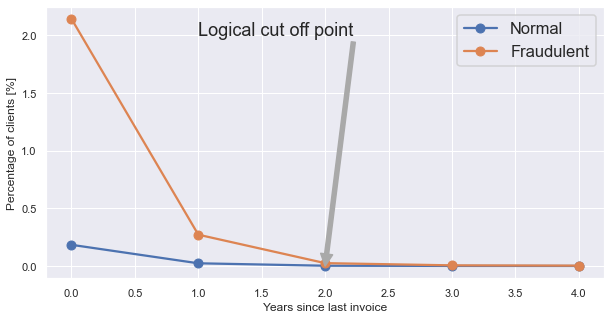

In [186]:
month_check = invoice_data[:].merge(client_data,on='client_id')
months =[]
for i in range(5):
    months.append(month_check[(month_check['months_number']>i*12)&(month_check['target']==1)].groupby('client_id').sum().shape[0])
    
fig,ax = plt.subplots(figsize=(10,5))
sns.set_context('talk')
sns.set_style("darkgrid")
plt.plot((np.array(months)/month_check[month_check['target']==0].shape[0])*100,marker='o',label='Normal')
plt.plot((np.array(months)/month_check[month_check['target']==1].shape[0])*100,marker='o',label='Fraudulent')
plt.legend()
plt.ylabel('Percentage of clients [%]');
plt.xlabel('Years since last invoice');
ax.annotate("Logical cut off point", (2,0),xytext = (1,2), arrowprops = dict(color = "darkgrey"));

As shown in the above graph we can safely remove the invoices that have large numbers in the 'months_number' column. Shown in the above graph, rows with larger than two year since the last invoice corresponds to removing 0.04% of the fraudulent clients.

In [187]:
invoice_data.drop(invoice_data[invoice_data.months_number > 24].index,inplace=True)

In [188]:
invoice_data['months_number'].describe()

count    4.473221e+06
mean     4.236397e+00
std      1.770281e+00
min      0.000000e+00
25%      4.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      2.400000e+01
Name: months_number, dtype: float64

In [189]:
print('Number of client: ',client_data.shape[0])
print('Number of clients in reduced invoice data set: ',invoice_data['client_id'].unique().shape[0])
print('Number of removed clients: ',client_data.shape[0]-invoice_data['client_id'].unique().shape[0])

Number of client:  135493
Number of clients in reduced invoice data set:  135356
Number of removed clients:  137


Looking at the data for month count, i.e., the number of months in between invoices, we explored various values for the months trying to see where the cutoff point was for useful data, as seen on the graph the vast majority of the non-useful outliers where over 2 years(24 months) and the amount of data loss is minimal if we drop those, less than 1.1%

# Counter status

In [190]:
print(f'Counter state:\n\ntakes up to 5 values such as working fine, not working, on hold statue\n\n {invoice_data.counter_statue.unique()}\n')

Counter state:

takes up to 5 values such as working fine, not working, on hold statue

 ['0' '1' '5' '4' '3' '2' 'A' '618' '420']



In [191]:
print(invoice_data["counter_statue"].value_counts())
ind = invoice_data["counter_statue"].value_counts()
for i, x in enumerate(ind):
    print((ind[i] / len(invoice_data["counter_statue"])) * 100)

0      4375572
1        74025
5        20590
4         2718
3          258
2           32
A           13
618         12
420          1
Name: counter_statue, dtype: int64
97.81703161994454
1.6548478154779296
0.4602947182801833
0.06076158544368812
0.005767656013418519
0.0007153681877108241
0.0002906183262575223
0.00026826307039155904
2.2355255865963252e-05


Evaluating the counter further.

Looking at the feature counter statue we could deduce that the amount of values outside the expected format(0 to 5) are very few, under 0,4 % and none where linked to fraudulent clients, thus we can drop them to clean the data a tiny bit more.

In [192]:
invoice_data = invoice_data[~invoice_data['counter_statue'].isin(['A','618','420'])]

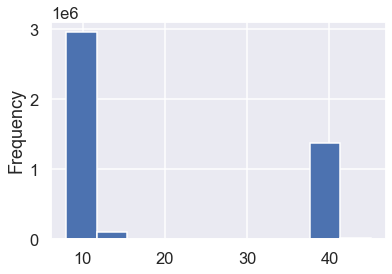

In [193]:
invoice_data['tarif_type'].plot(kind='hist');
sns.set_context('talk')
sns.set_style("darkgrid")

Quick sanity check for columns

In [194]:
print(invoice_data['counter_statue'].unique())

['0' '1' '5' '4' '3' '2']


# Tarif type

Looking at the feature counter statue we could deduce that the amount of values outside the expected format(0 to 5) are very few, under 0,4 % and none where linked to fraudulent clients, thus we can drop them to clean the data a tiny bit more.

In [195]:
print(invoice_data.groupby('tarif_type').size())

invoice_data = invoice_data[~invoice_data['tarif_type'].isin([18,24,27,42])]

print(invoice_data.groupby('tarif_type').size())

invoice_data.drop(columns=['tarif_type'],inplace=True)
#last minute dropping of this column because the groups are not the same as in the test data and so one hot encoding
#lead to different number of columns

tarif_type
8          43
9        6037
10     275880
11    2678079
12      11314
13      11627
14      11581
15      72375
18          4
21        104
24          9
27          1
29      10079
30         35
40    1379398
42          1
45      16628
dtype: int64
tarif_type
8          43
9        6037
10     275880
11    2678079
12      11314
13      11627
14      11581
15      72375
21        104
29      10079
30         35
40    1379398
45      16628
dtype: int64


# Counter coefficient

In [196]:
invoice_data.groupby('counter_coefficient').size()

counter_coefficient
0          44
1     4471643
2         812
3         321
4          12
5           1
10          6
11          1
20          3
30        137
33          1
40        197
50          2
dtype: int64

We decided to drop the feature because it didn’t have a lot of variances.

In [197]:
invoice_data.drop(columns=['counter_coefficient'],inplace=True)

In [198]:
client_data.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_amount,contract_time_length,contract_time_to_latest
0,60,train_Client_0,11,101,1994-12-31,0.0,35,27,25
1,69,train_Client_1,11,107,2002-05-29,0.0,37,19,17
2,62,train_Client_10,11,301,1986-03-13,0.0,18,35,33
3,69,train_Client_100,11,105,1996-11-07,0.0,20,25,16
4,62,train_Client_1000,11,303,2014-10-14,0.0,14,7,5


# One hot encoding 

We then want to one hot encode the categorical variables for the model to process 

In [199]:
#Drop columns not deemed neccesary
reduced_invoice_data = invoice_data.drop(columns=['counter_code','counter_number','old_index','new_index','invoice_date'])

reduced_client_data = client_data.drop(columns=['disrict','region','creation_date'])

In [200]:
#Hot encode the categorical variables for the invoice dataset
cat_cols_invoice = ['counter_statue','reading_remarque','counter_type']

invoice_cat = pd.get_dummies(reduced_invoice_data,columns=cat_cols_invoice)
invoice_cat.head()

,client_id,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,months_number,index_dif,counter_statue_0,counter_statue_1,counter_statue_2,counter_statue_3,counter_statue_4,counter_statue_5,reading_remarque_6,reading_remarque_7,reading_remarque_8,reading_remarque_9,counter_type_ELEC,counter_type_GAZ
0,train_Client_0,82,0,0,0,4,82,1,0,0,0,0,0,0,0,1,0,1,0
1,train_Client_0,1200,184,0,0,4,1384,1,0,0,0,0,0,1,0,0,0,1,0
2,train_Client_0,123,0,0,0,4,123,1,0,0,0,0,0,0,0,1,0,1,0
3,train_Client_0,102,0,0,0,4,102,1,0,0,0,0,0,0,0,1,0,1,0
4,train_Client_0,572,0,0,0,12,572,1,0,0,0,0,0,0,0,0,1,1,0


In [201]:
#Hot encode the categorical variables for the client dataset
cat_cols_client = ['client_catg']

client_cat = pd.get_dummies(reduced_client_data,columns=cat_cols_client)
client_cat.head()

,client_id,target,invoice_amount,contract_time_length,contract_time_to_latest,client_catg_11,client_catg_12,client_catg_51
0,train_Client_0,0.0,35,27,25,1,0,0
1,train_Client_1,0.0,37,19,17,1,0,0
2,train_Client_10,0.0,18,35,33,1,0,0
3,train_Client_100,0.0,20,25,16,1,0,0
4,train_Client_1000,0.0,14,7,5,1,0,0


Deriving mean values for the one hot encoded categorical variables as this indicated their proportion within each client set of invoices

In [202]:
df_mean = invoice_cat.groupby('client_id').agg('mean').iloc[:,6:]
df_mean.head()

,counter_statue_0,counter_statue_1,counter_statue_2,counter_statue_3,counter_statue_4,counter_statue_5,reading_remarque_6,reading_remarque_7,reading_remarque_8,reading_remarque_9,counter_type_ELEC,counter_type_GAZ
client_id,,,,,,,,,,,,
train_Client_0,1.0,0.0,0.0,0.0,0.0,0.0,0.600000,0.0,0.228571,0.171429,1.0,0.0
train_Client_1,1.0,0.0,0.0,0.0,0.0,0.0,0.540541,0.0,0.162162,0.297297,1.0,0.0
train_Client_10,1.0,0.0,0.0,0.0,0.0,0.0,0.555556,0.0,0.277778,0.166667,1.0,0.0
train_Client_100,1.0,0.0,0.0,0.0,0.0,0.0,0.950000,0.0,0.000000,0.050000,1.0,0.0
train_Client_1000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.142857,0.857143,1.0,0.0


Deriving statistical features (Min, Max, Median , Mean and Standard deviation) for the discrete data columns of each clients set of invoices

In [203]:
df_cons= invoice_cat.groupby('client_id').agg({'consommation_level_1': ['min', 'max','mean','median','std'],
                                     'consommation_level_2': ['min', 'max','mean','median','std'],
                                     'consommation_level_3': ['min', 'max','mean','median','std'],
                                     'consommation_level_4': ['min', 'max','mean','median','std'],
                                     'index_dif': ['min', 'max','mean','median','std'],
                                     'months_number': ['min', 'max','mean','median','std']})

df_cons.columns = ['consommation_level_1_min','consommation_level_1_max','consommation_level_1_mean','consommation_level_1_median','consommation_level_1_std','consommation_level_2_min','consommation_level_2_max','consommation_level_2_mean','consommation_level_2_median','consommation_level_2_std','consommation_level_3_min','consommation_level_3_max','consommation_level_3_mean','consommation_level_3_median','consommation_level_3_std','consommation_level_4_min','consommation_level_4_max','consommation_level_4_mean','consommation_level_4_median','consommation_level_4_std','index_dif_min','index_dif_max','index_dif_mean','index_dif_median','index_dif_std','months_number_min','months_number_max','months_number_mean','months_number_median','months_number_std']
df_cons.head()

,consommation_level_1_min,consommation_level_1_max,consommation_level_1_mean,consommation_level_1_median,consommation_level_1_std,consommation_level_2_min,consommation_level_2_max,consommation_level_2_mean,consommation_level_2_median,consommation_level_2_std,...,index_dif_min,index_dif_max,index_dif_mean,index_dif_median,index_dif_std,months_number_min,months_number_max,months_number_mean,months_number_median,months_number_std
client_id,,,,,,,,,,,,,,,,,,,,,
train_Client_0,38,1200,352.400000,267.0,310.343472,0,186,10.571429,0.0,43.568935,...,38,1386,362.971429,267.0,341.553930,2,12,4.628571,4.0,2.101620
train_Client_1,190,1207,557.540541,520.0,197.935960,0,0,0.000000,0.0,0.000000,...,190,1207,557.540541,520.0,197.935960,2,8,4.324324,4.0,1.375461
train_Client_10,188,2400,798.611111,655.5,513.841374,0,682,37.888889,0.0,160.748942,...,188,3082,836.500000,655.5,646.808386,4,12,6.444444,4.0,3.399346
train_Client_100,0,15,1.200000,0.0,3.607011,0,0,0.000000,0.0,0.000000,...,0,15,1.200000,0.0,3.607011,4,6,4.200000,4.0,0.615587
train_Client_1000,124,800,663.714286,770.0,224.831365,0,400,104.857143,0.0,167.155320,...,124,2382,922.642857,770.0,633.485669,2,4,3.714286,4.0,0.726273


In [204]:
#merging the grouped invoice data set of means and describe()
derived_invoice = df_cons.merge(df_mean,on='client_id')

In [205]:
#merging grouped invoice dataset with the original client dataset
final_dataset = client_cat.merge(derived_invoice,on='client_id')
final_dataset.drop(columns=['client_id'],inplace=True)

In [206]:
final_dataset.fillna(0,inplace=True) #There are NaN where because standard deviation of one invoice gives error
final_dataset.shape

(135354, 49)

In [207]:
final_dataset.head()

,target,invoice_amount,contract_time_length,contract_time_to_latest,client_catg_11,client_catg_12,client_catg_51,consommation_level_1_min,consommation_level_1_max,consommation_level_1_mean,...,counter_statue_2,counter_statue_3,counter_statue_4,counter_statue_5,reading_remarque_6,reading_remarque_7,reading_remarque_8,reading_remarque_9,counter_type_ELEC,counter_type_GAZ
0,0.0,35,27,25,1,0,0,38,1200,352.400000,...,0.0,0.0,0.0,0.0,0.600000,0.0,0.228571,0.171429,1.0,0.0
1,0.0,37,19,17,1,0,0,190,1207,557.540541,...,0.0,0.0,0.0,0.0,0.540541,0.0,0.162162,0.297297,1.0,0.0
2,0.0,18,35,33,1,0,0,188,2400,798.611111,...,0.0,0.0,0.0,0.0,0.555556,0.0,0.277778,0.166667,1.0,0.0
3,0.0,20,25,16,1,0,0,0,15,1.200000,...,0.0,0.0,0.0,0.0,0.950000,0.0,0.000000,0.050000,1.0,0.0
4,0.0,14,7,5,1,0,0,124,800,663.714286,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.142857,0.857143,1.0,0.0


## Data preparation 


In [214]:
#Splitting the data
X = final_dataset.drop(columns=['target']).values
y = final_dataset['target'].values

In [215]:
from sklearn.model_selection import train_test_split
# split training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5, random_state=42)

In [216]:
#Redistributing the classes

# under sample majority to have the minority class equal 50% of the majority's size
under = RandomUnderSampler(sampling_strategy = 0.3, random_state = 42)


X_train, y_train = under.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('Class count after:', counter)

Class count after: Counter({0.0: 12553, 1.0: 3766})


In [217]:
#Scaling the data
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler

scale_pipeline = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('minmax', MinMaxScaler())])

X_train = scale_pipeline.fit_transform(X_train)
X_valid = scale_pipeline.fit_transform(X_valid)

## Model choice

In [102]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [103]:
best_models = []

## Model training 

# Using gridsearch for hyperparameter testing

# Decision Tree Classifier

# Using gridsearch for the best hyperparameters for the DecisionTreeClassifier model

In [104]:
from sklearn.model_selection import GridSearchCV

param_DTC = {
    'criterion':['gini','entropy'],
    'max_depth':[2,3,4,5,10,50,100,500,1000,None],
    'splitter':['best','random'],
    'min_samples_split':[1,2,5,10,50,100,500,1000,None],
    'min_samples_leaf':[1,2,5,10],
    'max_features':['auto', 'sqrt', 'log2'],
    'random_state':[42]
}
# Create a based model
DTF = DecisionTreeClassifier()
# Instantiate the grid search model
grid_DTF = GridSearchCV(estimator = DTF, param_grid = param_DTC, cv = 3, n_jobs = -1, verbose = 2)

In [105]:
grid_DTF.fit(X_train, y_train)
grid_DTF.best_params_

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


/Users/torick/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.76922606 ... 0.76965491        nan        nan]
  warnings.warn(


{'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'log2',
 'min_samples_leaf': 10,
 'min_samples_split': 500,
 'random_state': 42,
 'splitter': 'best'}

In [106]:
best_dt_model = grid_DTF.best_estimator_
best_dt_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=50, max_features='log2',
                       min_samples_leaf=10, min_samples_split=500,
                       random_state=42)

In [107]:
DT_pred = best_dt_model.predict(X_valid)
best_models.append(best_dt_model)

# K-NeighborsClassifier

# Using gridsearch to find the best hyperparameters for the K-NeighborsClassifier model

In [108]:
param_KNN = {
    'n_neighbors':[2,3,4,5,6]
}
# Create a based model
KNN = KNeighborsClassifier()
# Instantiate the grid search model
gird_KNN = GridSearchCV(estimator = KNN, param_grid = param_KNN, cv = 3, n_jobs = -1, verbose = 2)

In [109]:
gird_KNN.fit(X_train, y_train)
gird_KNN.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


{'n_neighbors': 6}

In [110]:
best_KNN_model = gird_KNN.best_estimator_
best_KNN_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6)

In [111]:
KNN_pred = best_KNN_model.predict(X_valid)
best_models.append(best_KNN_model)

# Random Forest Classifier

# Using gridsearch to find the best hyperparameters for the RandomForestClassifier

In [112]:
param_RFC = {
    'max_depth': [70, 90, 100, 110],
    'n_estimators': [100, 200, 1000]
}
# Create a based model
RFC = RandomForestClassifier()
# Instantiate the grid search model
grid_RFC = GridSearchCV(estimator = RFC, param_grid = param_RFC, cv = 3, n_jobs = -1, verbose = 2)

In [113]:
grid_RFC.fit(X_train, y_train)
grid_RFC.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


{'max_depth': 90, 'n_estimators': 1000}

In [114]:
best_RFC_model = grid_RFC.best_estimator_
best_RFC_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=90, n_estimators=1000)

In [115]:
RFC_pred = best_RFC_model.predict(X_valid)
best_models.append(best_RFC_model)

# Logistic Regression

# Using gridsearch to find the best hyperparameters for the Logistic regression model

In [116]:
param_LR = {
    'penalty': ['l1','l2','elasticnet','none'],
    'tol': [0.1, 0.001, 0.0001, 1,10,100],
    'C': [1,2,3,4,5,10,15,20,50,100,200],
    'random_state':[42],
    'solver':['newton-cg','lbfgs','sag','saga'],
    'n_jobs':[-1]
}
# Create a based model
LR = LogisticRegression()
# Instantiate the grid search model
grid_LR = GridSearchCV(estimator = LR, param_grid = param_LR, cv = 3, n_jobs = -1, verbose = 2)

In [117]:
grid_LR.fit(X_train, y_train)
grid_LR.best_params_

Fitting 3 folds for each of 1056 candidates, totalling 3168 fits


/Users/torick/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.76585541 0.76585541 0.76585541]
  warnings.warn(


{'C': 5,
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'newton-cg',
 'tol': 0.1}

In [118]:
best_LR_model = grid_LR.best_estimator_
best_LR_model.fit(X_train, y_train)

LogisticRegression(C=5, n_jobs=-1, random_state=42, solver='newton-cg', tol=0.1)

In [119]:
LR_pred = best_LR_model.predict(X_valid)
best_models.append(best_LR_model)

# Multinomial NB

# Building the MultinomialNB model

In [120]:
MNB = MultinomialNB()

MNB.fit(X_train, y_train)

MNB_pred = MNB.predict(X_valid)
best_models.append(MNB)

# Support vector Classifier

# Using gridsearch to find the best hyperparameters for the Support Vector Classifier model

In [121]:
param_SVC = {
    'kernel':['poly'],
    'degree':[2,3]
}
# Create a based model
SVC_ = SVC()
# Instantiate the grid search model
grid_SVC = GridSearchCV(estimator = SVC_, param_grid = param_SVC, cv = 3, n_jobs = -1, verbose = 2)

In [122]:
grid_SVC.fit(X_train, y_train)
grid_SVC.best_params_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


{'degree': 3, 'kernel': 'poly'}

In [123]:
best_SVC_model = grid_SVC.best_estimator_
best_SVC_model.fit(X_train, y_train)

SVC(kernel='poly')

In [124]:
SVC_pred = best_SVC_model.predict(X_valid)
best_models.append(best_SVC_model)

In [125]:
scores_of_models = []

# Confusion matrixes of best models

# Here we plot the confusion matrix of the best hyperparameters for each model

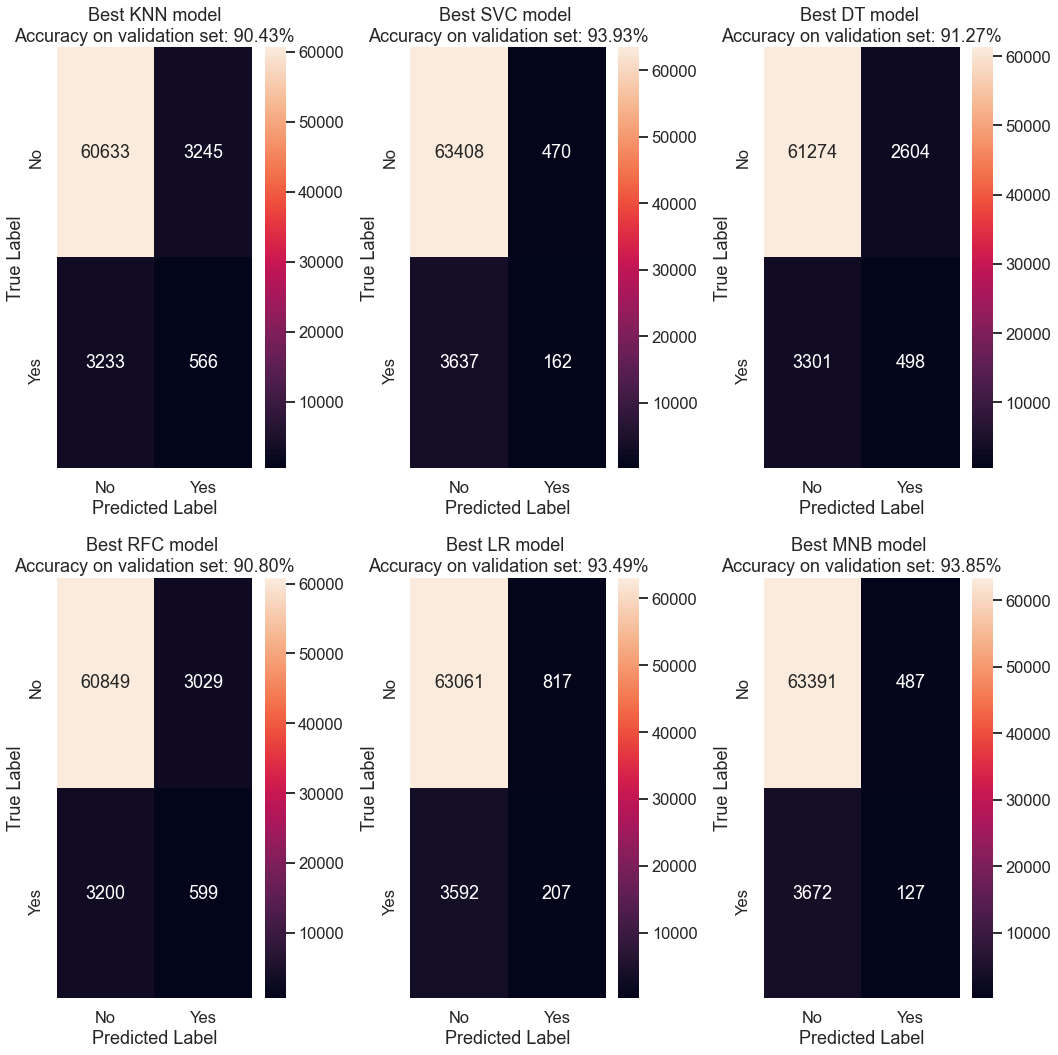

In [126]:
fig , ax = plt.subplots(2,3,figsize=(15,15))
ax = ax.flatten()
labels = ["No", "Yes"]

sns.heatmap(
    confusion_matrix(y_valid, KNN_pred),
    annot=True,fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
    ax=ax[0]
)
ax[0].set_ylabel('True Label')
ax[0].set_xlabel('Predicted Label')
score_KNN = accuracy_score(y_valid, KNN_pred) * 100
ax[0].set_title("Best KNN model\nAccuracy on validation set: {:.2f}%".format(score_KNN))

sns.heatmap(
    confusion_matrix(y_valid, SVC_pred),
    annot=True,
    fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
    ax=ax[1]
)
ax[1].set_ylabel('True Label')
ax[1].set_xlabel('Predicted Label')
score_SVC = accuracy_score(y_valid, SVC_pred) * 100
ax[1].set_title("Best SVC model \nAccuracy on validation set: {:.2f}%".format(score_SVC))

sns.heatmap(
    confusion_matrix(y_valid, DT_pred),
    annot=True,
    fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
    ax=ax[2]
)
ax[2].set_ylabel('True Label')
ax[2].set_xlabel('Predicted Label')
score_DT = accuracy_score(y_valid, DT_pred) * 100
ax[2].set_title("Best DT model \nAccuracy on validation set: {:.2f}%".format(score_DT))

sns.heatmap(
    confusion_matrix(y_valid, RFC_pred),
    annot=True,
    fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
    ax=ax[3]
)
ax[3].set_ylabel('True Label')
ax[3].set_xlabel('Predicted Label')
score_RFC = accuracy_score(y_valid, RFC_pred) * 100
ax[3].set_title("Best RFC model \nAccuracy on validation set: {:.2f}%".format(score_RFC))

sns.heatmap(
    confusion_matrix(y_valid, LR_pred),
    annot=True,
    fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
    ax=ax[4]
)
ax[4].set_ylabel('True Label')
ax[4].set_xlabel('Predicted Label')
score_LR = accuracy_score(y_valid, LR_pred) * 100
ax[4].set_title("Best LR model \nAccuracy on validation set: {:.2f}%".format(score_LR))

sns.heatmap(
    confusion_matrix(y_valid, MNB_pred),
    annot=True,
    fmt='d',
    yticklabels=labels,
    xticklabels=labels, 
    ax=ax[5]
)
ax[5].set_ylabel('True Label')
ax[5].set_xlabel('Predicted Label')
score_MNB = accuracy_score(y_valid, MNB_pred) * 100
ax[5].set_title("Best MNB model \nAccuracy on validation set: {:.2f}%".format(score_MNB))

scores_of_models.append(score_DT)
scores_of_models.append(score_KNN)
scores_of_models.append(score_RFC)
scores_of_models.append(score_LR)
scores_of_models.append(score_MNB)
scores_of_models.append(score_SVC)

plt.tight_layout()

In [127]:
# Building final database to show performance of the models.

In [128]:
# The best hyperparameters for each model
best_models

[DecisionTreeClassifier(criterion='entropy', max_depth=50, max_features='log2',
                        min_samples_leaf=10, min_samples_split=500,
                        random_state=42),
 KNeighborsClassifier(n_neighbors=6),
 RandomForestClassifier(max_depth=90, n_estimators=1000),
 LogisticRegression(C=5, n_jobs=-1, random_state=42, solver='newton-cg', tol=0.1),
 MultinomialNB(),
 SVC(kernel='poly')]

In [129]:
# All the validation scores for the models
scores_of_models

[91.27473144495175,
 90.42806270963547,
 90.79598681974674,
 93.48523131935518,
 93.85463303633436,
 93.93146859346602]

In [130]:
# Putting all the training scores in a list
train_scores = [grid_DTF.best_score_ * 100,gird_KNN.best_score_ * 100,grid_RFC.best_score_ * 100 ,grid_LR.best_score_ * 100, score_MNB,grid_SVC.best_score_ * 100]

In [131]:
#Calculating underfitting by subtracting the training scores from the validation scores
underfitting = []
for i in range(len(train_scores)):
    underfit = scores_of_models[i] - train_scores[i]
    underfitting.append(underfit)

In [132]:
# Here we see the ammount of underfitting
# Multinomial NB has a 0% because we did not tune hyperparameters
underfitting

[13.984469619500857,
 14.534937441510195,
 12.543664494420199,
 16.133687098063064,
 0.0,
 16.684092165417326]

In [133]:
# Calculating the ROC area under the curve
from sklearn.metrics import roc_auc_score

roc_scores = []

roc_DT = roc_auc_score(y_valid,DT_pred)
roc_scores.append(roc_DT)
roc_KNN = roc_auc_score(y_valid,KNN_pred)
roc_scores.append(roc_KNN)
roc_RFC = roc_auc_score(y_valid,RFC_pred)
roc_scores.append(roc_RFC)
roc_LR = roc_auc_score(y_valid,LR_pred)
roc_scores.append(roc_LR)
roc_MNB = roc_auc_score(y_valid,MNB_pred)
roc_scores.append(roc_MNB)
roc_SVC = roc_auc_score(y_valid,SVC_pred)
roc_scores.append(roc_SVC)


In [134]:
# Here we see the ROC area under the curves
roc_scores

[0.5451609597562924,
 0.5490933064931018,
 0.555127277656924,
 0.5208490086075753,
 0.5129029709428742,
 0.5176425124884967]

In [135]:
#Here we make a dataframe to show the performance of the models.
Names_models = ['DecisionTreeClassifier','K-NewestNeighborsClassifier','RandomForestClassifier','LogisticRegression','MultinomialNaiveBayes','SupportVectorClasiffier']
final_data = {
    'Model_hyperparameters':Names_models,
    'train_score': train_scores,
    'validation_score':scores_of_models,
    'underfitting %':underfitting,
    'ROC_AUC':roc_scores
}
final_df = pd.DataFrame(final_data)
final_df

,Model_hyperparameters,train_score,validation_score,underfitting %,ROC_AUC
0,DecisionTreeClassifier,77.290262,91.274731,13.984470,0.545161
1,K-NewestNeighborsClassifier,75.893125,90.428063,14.534937,0.549093
2,RandomForestClassifier,78.252322,90.795987,12.543664,0.555127
3,LogisticRegression,77.351544,93.485231,16.133687,0.520849
4,MultinomialNaiveBayes,93.854633,93.854633,0.000000,0.512903
5,SupportVectorClasiffier,77.247376,93.931469,16.684092,0.517643


## Model assesment

As seen above in the confusion matrixes the Decision Tree Classifier has the second best false negative value after Decision trees. But as you can also see it has the highest ROC area under the curve as well as the smallest ammount of underfitting out of all the models. The validation score is also the second highest but the highest validation score was logistic regression which had a 19% underfitting rate which makes it less ideal to use. Thus the RandomForestClassifier with tuned hyperparameters is chosen as the best model.

# Getting test data

In [212]:
def preprocessing(client_data,invoice_data):
#client_data = pd.read_csv('Data/client_train.csv',low_memory = False)
#invoice_data = pd.read_csv('Data/invoice_train.csv',low_memory = False)

    client_data['invoice_amount'] = invoice_data.groupby('client_id').size().values


    # Changing the client_data's column date to datetime
    client_data['creation_date']= pd.to_datetime(client_data['creation_date']);
    # Changing the invoice_data's column date to datetime
    invoice_data['invoice_date']= pd.to_datetime(invoice_data['invoice_date']);

    today = pd.to_datetime("today")
    # Add the contract length in years 
    client_data['contract_time_length'] = today.year - client_data['creation_date'].dt.year;

    client_data['contract_time_to_latest'] = invoice_data.groupby('client_id')['invoice_date'].max().dt.year.values- client_data['creation_date'].dt.year.values


    #Add index difference column
    invoice_data['index_dif'] = np.abs(invoice_data['new_index']-invoice_data['old_index']);




    #Add index difference column
    invoice_data['index_dif'] = np.abs(invoice_data['new_index']-invoice_data['old_index']);


    #Drop rows with large index difference
    #index_index_dif = invoice_data.merge(client_data,on='client_id')[invoice_data['index_dif'] > 2500].index
    #invoice_data.drop(index = index_index_dif,inplace = True)

    #invoice_data.drop(invoice_data[invoice_data.months_number > 24].index,inplace=True)

    consumption_headings = ['consommation_level_1','consommation_level_2','consommation_level_3','consommation_level_4']

    df = invoice_data[consumption_headings][ invoice_data[consumption_headings] > 0 ]


    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    index1 = invoice_data[consumption_headings] > (Q3 + 2 * IQR)


    #invoice_data.drop(index=invoice_data[index1.any(axis=1)].index,inplace=True)
    
    #invoice_data = invoice_data[~invoice_data['counter_statue'].isin(['A','618','420'])]
    
    #invoice_data = invoice_data[~invoice_data['tarif_type'].isin([18,24,27,42])]
    
    invoice_data.drop(columns=['tarif_type'],inplace=True)
    invoice_data.drop(columns=['counter_coefficient'],inplace=True)
    
    #Drop columns not deemed neccesary
    reduced_invoice_data = invoice_data.drop(columns=['counter_code','counter_number','old_index','new_index','invoice_date'])

    reduced_client_data = client_data.drop(columns=['disrict','region','creation_date'])


    #Hot encode the categorical variables for the invoice dataset
    cat_cols_invoice = ['counter_statue','reading_remarque','counter_type']

    invoice_cat = pd.get_dummies(reduced_invoice_data,columns=cat_cols_invoice);

    #Hot encode the categorical variables for the client dataset
    cat_cols_client = ['client_catg']

    client_cat = pd.get_dummies(reduced_client_data,columns=cat_cols_client);

    df_mean = invoice_cat.groupby('client_id').agg('mean').iloc[:,6:];

    df_cons= invoice_cat.groupby('client_id').agg({'consommation_level_1': ['min', 'max','mean','median','std'],
                                     'consommation_level_2': ['min', 'max','mean','median','std'],
                                     'consommation_level_3': ['min', 'max','mean','median','std'],
                                     'consommation_level_4': ['min', 'max','mean','median','std'],
                                     'index_dif': ['min', 'max','mean','median','std'],
                                     'months_number': ['min', 'max','mean','median','std']})

    df_cons.columns = ['consommation_level_1_min','consommation_level_1_max','consommation_level_1_mean','consommation_level_1_median','consommation_level_1_std','consommation_level_2_min','consommation_level_2_max','consommation_level_2_mean','consommation_level_2_median','consommation_level_2_std','consommation_level_3_min','consommation_level_3_max','consommation_level_3_mean','consommation_level_3_median','consommation_level_3_std','consommation_level_4_min','consommation_level_4_max','consommation_level_4_mean','consommation_level_4_median','consommation_level_4_std','index_dif_min','index_dif_max','index_dif_mean','index_dif_median','index_dif_std','months_number_min','months_number_max','months_number_mean','months_number_median','months_number_std']



    #merging the grouped invoice data set of means and describe()
    derived_invoice = df_cons.merge(df_mean,on='client_id');

    #merging grouped invoice dataset with the original client dataset
    final_dataset = client_cat.merge(derived_invoice,on='client_id')
    final_dataset.drop(columns=['client_id'],inplace=True)

    final_dataset.fillna(0,inplace=True) #There are NaN where because standard deviation of one invoice gives error

    X = final_dataset#.drop(columns=['target']).values
    #y = final_dataset['target'].values
    return X#,y

In [221]:
#Load the test data
client_test_data = pd.read_csv('Data/client_test.csv',low_memory = False)
invoice_test_data = pd.read_csv('Data/invoice_test.csv',low_memory = False)


In [218]:
#Best performaning model

#Train with the correct rfc model , optimal
from sklearn.ensemble import RandomForestClassifier

best_model = RandomForestClassifier(max_depth=90, n_estimators=1000)

best_model.fit(X_train, y_train)
best_model.score(X_valid, y_valid)

0.902448394580138

In [222]:
X_test = preprocessing(client_test_data,invoice_test_data)

X_test = scale_pipeline.fit_transform(X_test)

y_test = best_model.predict(X_test)

In [223]:
client_list = client_test_data['client_id']
final_output = pd.DataFrame({'client_id':client_list , 'target': y_test})

(array([55373.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2696.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

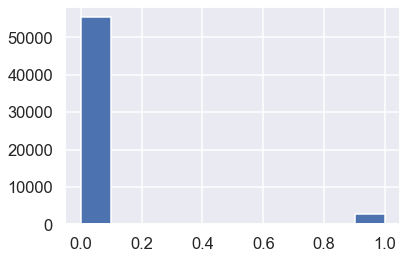

In [224]:
plt.hist(y_test)

In [226]:
final_output.head()

,client_id,target
0,test_Client_0,0.0
1,test_Client_1,1.0
2,test_Client_10,0.0
3,test_Client_100,0.0
4,test_Client_1000,0.0


In [228]:
final_output.to_csv('Group_5_submission.csv', index=False)